In [53]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statistics import mean
from datetime import date
import file

In [54]:
# Define the ticker symbol
tickerSymbol = 'NVDA'

# Get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
history = tickerData.history(interval='1wk', start='2021-1-1', end=date.today())
display(history)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-01-01 00:00:00-05:00,13.073098,13.620045,12.556080,13.312278,1925304000,0.0,0.0
2021-01-08 00:00:00-05:00,13.330731,13.927808,13.010993,13.168866,1595496000,0.0,0.0
2021-01-15 00:00:00-05:00,13.196549,13.965966,12.813462,13.834529,1100320000,0.0,0.0
2021-01-22 00:00:00-05:00,13.707335,13.808843,12.763335,13.019973,1261500000,0.0,0.0
2021-01-29 00:00:00-05:00,13.043916,13.898629,12.872075,13.631765,1155944000,0.0,0.0
...,...,...,...,...,...,...,...
2024-07-26 00:00:00-04:00,116.190002,120.160004,102.540001,109.209999,2025021000,0.0,0.0
2024-08-02 00:00:00-04:00,103.760002,108.800003,90.690002,104.970001,2247232400,0.0,0.0
2024-08-09 00:00:00-04:00,105.639999,123.239998,103.430000,122.860001,1586383900,0.0,0.0


In [55]:
max_weeks = 52

In [56]:

gap = (1/90)*100

option_prices = {}
print('option leverages:')
for w in sorted(option_prices.keys()):
    print(f'\t{w:2}w', *[f'{x:4.1f}' for x in option_prices[w]])

option_leverage = {w:mean(option_prices[w]) for w in option_prices}
option_leverage |= {1: 45.048954161103694,
 2: 28.34645669291339,
 3: 23.078757717985823,
 4: 19.33139534883721,
 5: 17.06700379266751,
 6: 15.620063191153237,
 7: 14.24426477485154,
 8: 13.38747901649057,
 9: 11.738148984198647,
 10: 12.073272273105745,
 11: 11.153846153846153,
 12: 10.614525139664805,
 13: 9.758771929824562,
 14: 9.537422037422036,
 15: 9.183576410906785,
 16: 8.996728462377318,
 17: 8.391608391608392,
 18: 8.289756220790704,
 19: 8.157389635316699,
 20: 7.906976744186046,
 21: 7.758620689655173,
 22: 7.539353769676885,
 23: 7.381756756756756,
 24: 7.292856343074684,
 25: 7.112068965517242,
 26: 6.854838709677419}
print('mean option leverage, break even:')
for w in sorted(option_leverage.keys()):
    print(f'\t{w:2}w {option_leverage[w]:4.1f} {gap + 100/option_leverage[w]:4.1f}%')
print(f'option gap: {gap:.2f}%')

file.save_option_leverage(tickerSymbol, option_leverage)

option leverages:
mean option leverage, break even:
	 1w 45.0  3.3%
	 2w 28.3  4.6%
	 3w 23.1  5.4%
	 4w 19.3  6.3%
	 5w 17.1  7.0%
	 6w 15.6  7.5%
	 7w 14.2  8.1%
	 8w 13.4  8.6%
	 9w 11.7  9.6%
	10w 12.1  9.4%
	11w 11.2 10.1%
	12w 10.6 10.5%
	13w  9.8 11.4%
	14w  9.5 11.6%
	15w  9.2 12.0%
	16w  9.0 12.2%
	17w  8.4 13.0%
	18w  8.3 13.2%
	19w  8.2 13.4%
	20w  7.9 13.8%
	21w  7.8 14.0%
	22w  7.5 14.4%
	23w  7.4 14.7%
	24w  7.3 14.8%
	25w  7.1 15.2%
	26w  6.9 15.7%
option gap: 1.11%


In [57]:
stock_change = [None]
option_performance = []
for weeks in range(1, max_weeks+1):
    stock_changes = history['Close'].pct_change(periods=weeks) * 100
    stock_change.append(stock_changes.median())
    window_max = history['High'].rolling(window=pd.api.indexers.FixedForwardWindowIndexer(window_size=weeks)).max()

    if weeks in option_leverage:
        lvr = option_leverage[weeks]
        option_profits = ((stock_changes[weeks:] - gap) * lvr - 100).clip(lower=-100)
        mean_profit = option_profits.mean() #* 52 / weeks # annualized
        median_profit = option_profits.median()
        positive_percent = (option_profits > 0).mean() * 100
        wmax = (((window_max / history['Open'] - 1) * 100 - gap) * lvr - 100).clip(lower=-100).median() - 100
        option_performance.append([weeks, mean_profit, positive_percent, wmax, median_profit])
        history[f'Option {weeks}w'] = option_profits # * 52 / weeks # annualized

In [58]:
print('Option performance (weeks, profit, positive, w max):')
for p in option_performance:
    weeks = p[0]
    print(f'\t{weeks:2}w {p[1]:4.0f}% {p[2]:3.0f}% {p[3]:4.0f}%')

Option performance (weeks, profit, positive, w max):
	 1w   30%  40%  -48%
	 2w   49%  42%  -15%
	 3w   71%  47%   -3%
	 4w   77%  46%   16%
	 5w   87%  46%   25%
	 6w   98%  50%   30%
	 7w  105%  52%   34%
	 8w  117%  55%   49%
	 9w  111%  57%   34%
	10w  141%  60%   66%
	11w  142%  61%   94%
	12w  154%  64%  122%
	13w  155%  62%  128%
	14w  169%  63%  160%
	15w  176%  61%  226%
	16w  189%  61%  225%
	17w  188%  61%  215%
	18w  204%  63%  221%
	19w  220%  66%  240%
	20w  229%  65%  230%
	21w  243%  64%  227%
	22w  252%  65%  237%
	23w  262%  67%  253%
	24w  276%  69%  258%
	25w  283%  69%  268%
	26w  285%  68%  269%


In [59]:
from file import save_file

save_file(tickerSymbol, option_performance)

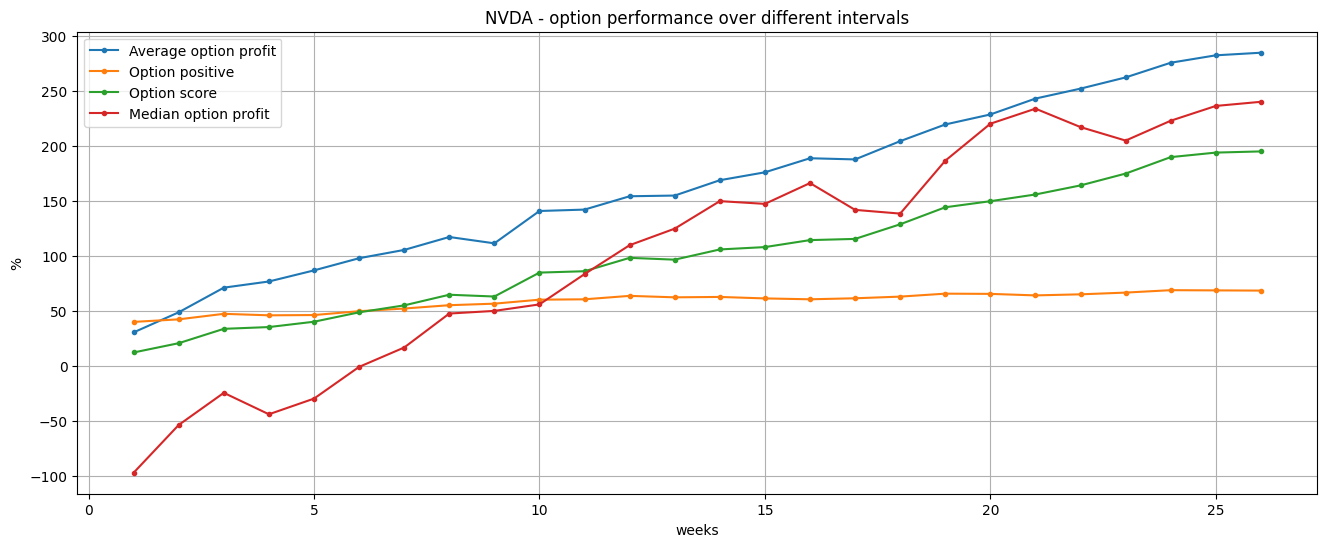

In [60]:
plt.figure(figsize=(16,6))
option_weeks = [p[0] for p in option_performance]
option_profit = [p[1] for p in option_performance]
option_positive = [p[2] for p in option_performance]
option_mprofit = [p[4] for p in option_performance]
option_score = [x * y / 100 for x, y in zip(option_profit, option_positive)]
plt.plot(option_weeks, option_profit, label='Average option profit', marker='.')
plt.plot(option_weeks, option_positive, label='Option positive', marker='.')
plt.plot(option_weeks, option_score, label='Option score', marker='.')
plt.plot(option_weeks, option_mprofit, label='Median option profit', marker='.')
plt.legend()
plt.title(f'{tickerSymbol} - option performance over different intervals')
plt.xlabel('weeks')
plt.ylabel('%')
plt.grid()
plt.show()

In [68]:
weeks = 4
history['stock_change'] = history['Close'].pct_change(periods=weeks) * 100
history['whigh'] = history['High'].rolling(window=pd.api.indexers.FixedForwardWindowIndexer(window_size=weeks)).max()
lvr = option_leverage[weeks]
history['wmax_profit'] = (((history['whigh'] / history['Open'] - 1) * 100 - gap) * lvr - 100).clip(lower=-100)


C to 4w low: -0.09284803511353645


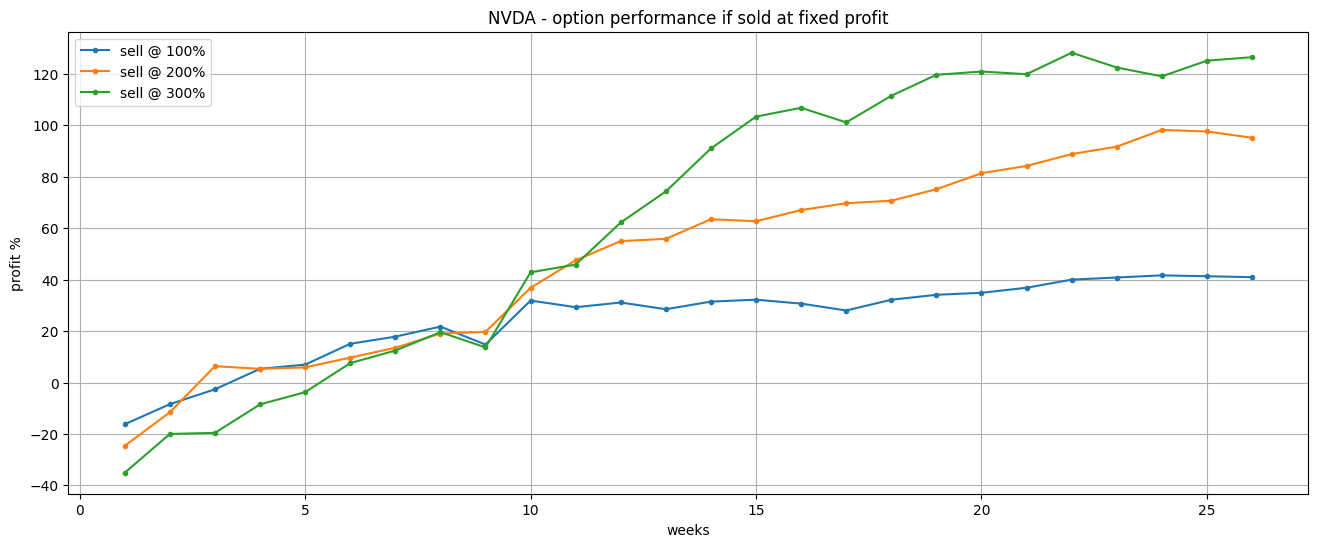

In [62]:
plt.figure(figsize=(16,6))

for percent in [100,200,300]:
    data = {}
    for weeks in option_leverage:
        lvr = option_leverage[weeks]
        window_max = history['High'].rolling(window=pd.api.indexers.FixedForwardWindowIndexer(window_size=weeks)).max()
        wmax = (((window_max / history['Open'] - 1) * 100 - gap) * lvr - 100).clip(lower=-100)
        wmax = wmax.dropna()
        q = (wmax >= percent).mean()
        data[weeks] = q * (percent + 100) - 100

    plt.plot(*zip(*sorted(data.items())), label=f'sell @ {percent}%', marker='.')

plt.legend(loc='best')
plt.title(f'{tickerSymbol} - option performance if sold at fixed profit')
plt.xlabel('weeks')
plt.ylabel('profit %')
plt.grid()
plt.show()

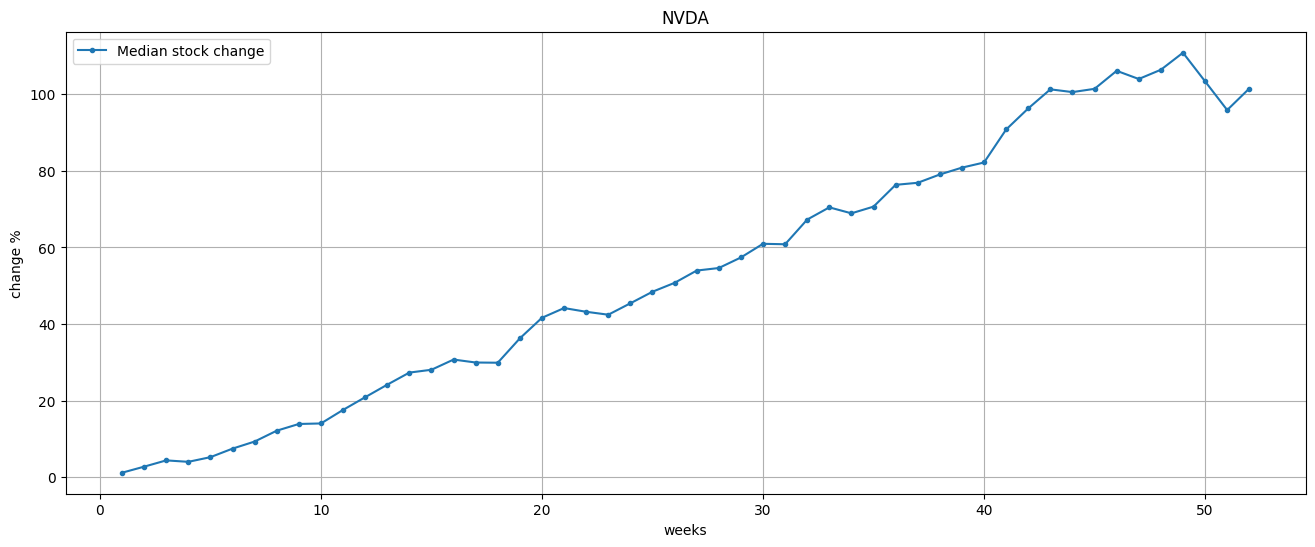

In [63]:
plt.figure(figsize=(16,6))
plt.plot(stock_change, label='Median stock change', marker='.')
plt.legend(loc='best')
plt.title(tickerSymbol)
plt.xlabel('weeks')
plt.ylabel('change %')
plt.grid()
plt.show()

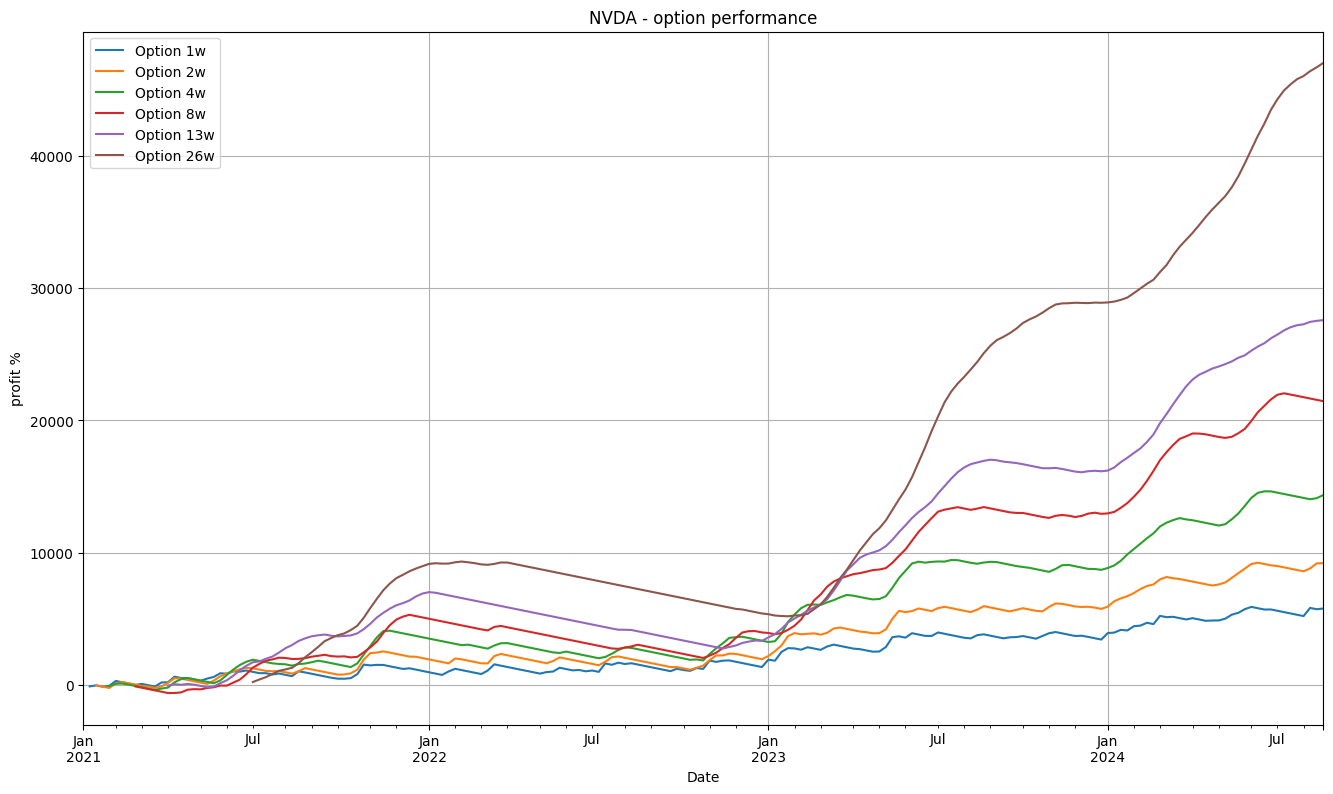

In [66]:
plt.figure(figsize=(16,9))

for w in [1,2,4,8,13,26]:
    history[f'Option {w}w'].cumsum().plot()

plt.legend()
plt.title(f'{tickerSymbol} - option performance')
plt.ylabel('profit %')
plt.grid()
plt.show()


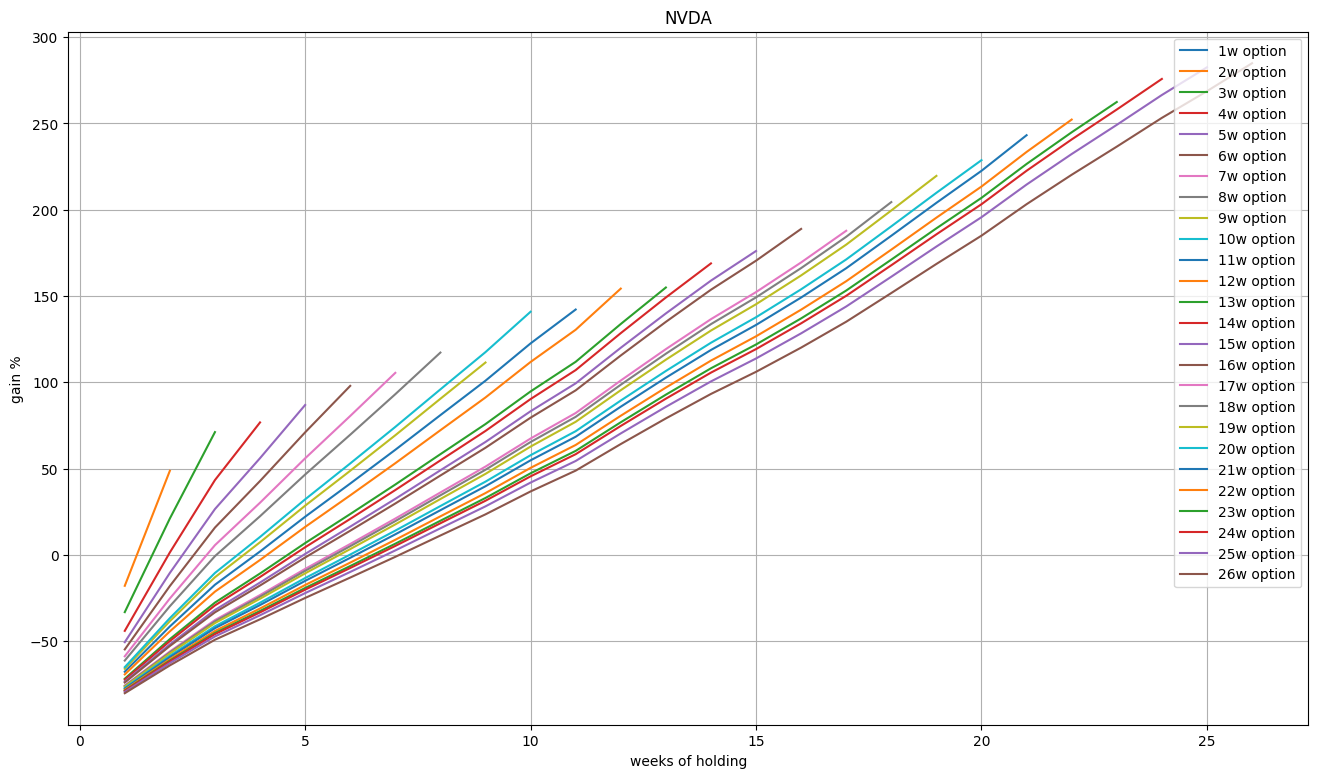

In [65]:
plt.figure(figsize=(16,9))

for w in option_leverage:
    lvr = option_leverage[w]
    gains = [None]
    for weeks in range(1, w+1):
        stock_changes = history['Close'].pct_change(periods=weeks) * 100
        option_profits = ((stock_changes[weeks:] - gap) * lvr - 100).clip(lower=-100)
        mean_profit = option_profits.mean() #* 52 / weeks # annualized
        gains.append(mean_profit if mean_profit > -100 else None)
    plt.plot(gains, label=f'{w}w option')
        
plt.legend(loc='upper right')
plt.title(tickerSymbol)
plt.xlabel('weeks of holding')
plt.ylabel('gain %')
plt.grid()
plt.show()